# Filtrage collaboratif

*ismael Bonneau*

Le filtrage collaboratif (en anglais: collaborative filtering) est une méthode utilisée par les systèmes de recommandations.

Une méthode de recommandation classique et de recommander à un utilisateur des objets similaires de celui qu'il a déjà aimé. Cette similarité, dans le cas d'une série ou d'un film par exemple peut se baser sur le genre, les acteurs en commun, le synopsis... Ainsi, si un utilisateur a aimé la série the punisher et luke cage, le système lui recommandera daredevil, shield agents, etc...
Cette stratégie a un défaut: les recommandations manquent de diversité et n'incitent pas l'utilisateur à explorer le catalogue.

Une deuxième approche est le **filtrage collaboratif**:
il permet de réaliser des prédictions automatiques ("filtrage") des intérêts d'un utilisateur en se basant sur les préférences d'un grand nombre d'autres utilisateurs ("collaboratif"), afin de recommander des produits (films, séries, musique, articles sur un site de e-commerce...) pertinents pour un utilisateur.

<img src="images/homer.png" width="500" />

-------------------------------------------------------------------------

### Principe:

L'hypothèse sous-jacente du filtrage collaboratif est que si une personne A a la même opinion qu'une personne B sur un sujet, A a plus de chance d'avoir la même opinion que B sur un autre sujet qu'une personne choisie au hasard.

Le système commence donc d'abord par collecter des avis d'un grand nombre d'utilisateurs sur un grand nombre d'objets (dans notre cas, des séries). Cet avis peut prendre plusieurs formes (1-5 étoiles, note sur 10, j'aime/je n'aime pas...) 

Puis, pour un utilisateur A le système trouve les utilisateurs qui ont les goûts les plus similaires. A partir des goûts de ces utilisateurs les plus similaires, le système peut prédir à l'utilisateur A une note pour chacun des objets qu'il n'a pas noté. 

Plusieurs types d'approche existent:

1) l'approche dite **memory-based**:
<p>
    Cette approche utilise les notes attribuées par les utilisateurs pour calculer la similarité entre les utilisateurs ou les objets. Elle se base sur un calcul de similarité et utilise des algorithmes classiques comme:
    <ul>
        <li>K plus proches voisins (K-NN) <a href="https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm">wikipédia</a></li>
        <li>Des mesures de similarité comme la similarité cosinus, la corrélation de Pearson...
            <a href=""></a></li>
    </ul>
</p>

2) l'approche dite **model-based**: 
<p>
    Cette approche utilise des techniques de machine learning et de data mining pour attribuer des notes couples utilisateur-objet. 
<ul>
    <li>Analyse en composantes principales (PCA) <a href="https://en.wikipedia.org/wiki/Singular_value_decomposition">wikipédia</a></li>
    <li>Factorisation de matrice non négative (NNMF) <a href="https://en.wikipedia.org/wiki/Non-negative_matrix_factorization">wikipédia</a></li>
    <li>Bayesian Personalized Ranking (n'attribue pas de "notes" mais un classement) <a href="https://cran.r-project.org/web/packages/rrecsys/vignettes/b6_BPR.html">lien</a></li>
    <li>...Et bien d'autres (approches à base de clustering...)</li>
</ul>
</p>

pour en savoir plus sur le filtrage collaboratif: <a href="https://en.wikipedia.org/wiki/Collaborative_filtering">wikipédia (en anglais)</a>

<img src="images/Classification-of-collaborative-filtering-algorithms.png" width="600" />

image sources:

<a href="https://www.researchgate.net/profile/Kan_Zheng/publication/303556519/figure/fig4/AS:614297214414873@1523471277992/Classification-of-collaborative-filtering-algorithms.png">[1]</a> <a href="https://johnolamendy.wordpress.com/2015/10/14/collaborative-filtering-in-apache-spark/">[2]</a>

-------------------

### Notre but:

Nous allons mettre en oeuvre et comparer plusieurs approches de recommandation collaborative, en l'occurence les approches model-based. 

Notre but est d'implémenter et comparer qualitativement et quantitativement les algorithmes de factorisation de matrice non négative (NNMF), décomposition en valeurs singulières améliorée(SVD++), Bayesian Personalized Ranking, et différentes fonctions de coûts associées, sur un jeu de données collectés sur le site imdb.

### Données:

Nous partons d'une base de ${m = 48705}$ utilisateurs ayant noté ${n = 892}$ séries. Ces données sont extraites du site <a href="https://www.imdb.com/">imdb</a> (voir script <a href="https://github.com/ismaelbonneau/movie_recommender/blob/master/scraping/scrap.py">scraping/scraping.py</a>) et sont résumées dans une matrice de taille ${n,m}$ où chaque entrée ${(u, i)}$ de matrice contient la note que l'utilisateur ${u}$ a attribué à l'item (série) ${i}$, sur 10 (le site ayant choisi un système de notation sur 10 étoiles).

---------------------

### Rentrons dans le vif du sujet:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix, csr_matrix #matrice "sparse"
import seaborn as sns

sns.set(color_codes=True)
plt.style.use('seaborn-white')
%matplotlib inline

filename = "userratings.csv"
tableSeries = "series.csv"

### Récupérons les avis utilisateur

In [2]:
df = pd.read_csv(filename)
print("il y a {} utilisateurs et {} séries".format(df.shape[1], df.shape[0]))

il y a 48705 utilisateurs et 892 séries


**Ci dessous**, les premières lignes de la matrice, avec en ligne les séries et en colonne les utilisateurs. On peut voir que la plupart des cases sont vides (NaN), les utilisateurs n'ayant noté que très peu de séries.

In [3]:
df.head(4)

,Unnamed: 0,ToddTee,bkoganbing,betwana,fabiogaucho,killer1h,rasadi27,michael_cure,MashedA,drarthurwells,...,jimjohnson-57331,tatianavoloshka,hectorgarcia-41182,allisonbryan-30611,timothyquaid,eduardoellis,Chris_Tsimpoukas,ToxicAvox,DinoLord94,bratdawg
0,tt0035665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0042114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0043208,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0047708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Jetons un oeil à la distribution des données:

In [69]:
for seuil in [1, 5, 10]:
    c = len([a for a in (df.count(axis=0) > seuil) if a])/df.shape[1]
    print("{0:.2f}% des utilisateurs ont noté plus de ".format(
        100*c)+str(seuil)+" série ("+str(int(c*df.shape[1]))+" total)")
print("\n")   
for seuil in [2, 20, 50, 100]:
    c = len([a for a in (df.count(axis=1) > seuil) if a])/df.shape[0]
    print("{0:.2f}% des series ont reçu plus de ".format(
        100*c)+str(seuil)+" notes ("+str(int(c*df.shape[0]))+" total)")

13.55% des utilisateurs ont noté plus de 1 série (6598 total)
1.38% des utilisateurs ont noté plus de 5 série (670 total)
0.46% des utilisateurs ont noté plus de 10 série (226 total)


98.54% des series ont reçu plus de 2 notes (879 total)
69.62% des series ont reçu plus de 20 notes (621 total)
35.87% des series ont reçu plus de 50 notes (320 total)
19.28% des series ont reçu plus de 100 notes (172 total)


<img src="images/distribution_avis.png" width="900" />

L'histogramme révèle que les utilisateurs donnent très peu d'avis: 86,5% d'entre eux n'ont noté qu'une série. Les séries ont quant à elle plus d'avis: près de 20% des séries ont reçu plus de 100 notes, et 70% des séries ont reçu au moins 20 notes. Il faut choisir un **seuil de coupure** pour éliminer les utilisateurs ayant trop peu noté: nous choisissons arbitrairement de couper en-dessous de 4. Pour les séries, on gardera celles ayant reçu au moins 4 notes.

<img src="images/distribution_notes.png" />

### Résultat:

Beaucoup de ${1/20}$, beaucoup de ${10/10}$. Cet histogramme illustre un **phénomène connu en recommandation**: les utilisateurs ont tendance à ne noter que les films qui les ont marqués, soit positivement (j'ai adoré, je donne ${10/10}$) soit négativement (j'ai détesté, je donne un ${1/10}$). Ce phénomène est particulièrement illustré sur les utilisateurs qui notent peu: les utilisateurs qui notent beaucoup, avec un comportement sur le site de "critique amateur" ont eu tendance à noter la plupart des films qu'ils voient, et donc à donner des notes plus variées.

Il existe un autre phénomène en recommandation: 
On dit que les données sont 
- **MCAR** (Missing Completely At Random, en français "manquantes complètement au hasard"). 
- **MAR** (Missing At Random, en français "manquantes au hasard"). Contrairement à ce que l'on peut penser 

In [3]:
series = pd.read_csv(tableSeries)
series = series[["seriesname", "imdbId"]]

Retirons les noms de série, et enlevons les utilisateurs ayant noté moins de 4 séries et les séries notées moins de 4 fois:

In [4]:
#nous allons réaliser un mapping des imdbId de séries vers des entiers.
#on mémorise le mapping entier -> série en gardant les noms de série.
df.rename(columns={"Unnamed: 0":'item'}, inplace=True)
df = df.loc[:, (df.count(axis=0) >= 4)] #enlever les utilisateurs ayant noté moins de 5 séries
df = df.loc[(df.count(axis=1) >= 4), :] #enlever les séries ayant reçu moins de 4 notes

In [5]:
serie_dict = []
for imdbId in df["item"]:
    serie_dict.append(list(series[series["imdbId"] == imdbId]["seriesname"])[0])
    
df = df.drop(columns=['item']) #enlever la colonne des noms de série
df = df.transpose()

<img src="images/distribution_notes_apresfiltrage.png" />

### Masquage des valeurs manquantes:

Nous allons créer une variable "masque" booléen, qui nous servira pour l'étape suivante. On obtient un tableau de même dimension, dans lequel False indique une valeur manquante (à masquer pour la suite) et True une valeur observée.

In [6]:
train = df.notnull().values

In [7]:
df.columns = list(range(len(serie_dict)))

### Séparons nos données observées en train/test:

On sépare nos données en ensemble train/test. 20% de données observées en test, 80% en train.

In [8]:
import random

test_size = 0.2
test = train.copy()

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if train[i,j]:
            if random.random() < test_size:
                #ajouter dans test et enlever de train
                train[i,j] = False
            else:
                test[i,j] = False 

### Matrix Factorization: principe

Une des façons de faire du filtrage collaboratif par approche model-based est d'utiliser un algorithme de **factorisation de matrice**. 

On pose ${\mathbf{R}}$ la matrice des notes, $\mathbf{\hat{R}}$ la matrice que l'on cherche à construire, contenant toutes les notes existantes et prédites. Cette matrice est de dimension ${m, n}$ avec ${m}$ le nombre d'utilisateurs et ${n}$ le nombre de séries. On va chercher à trouver deux matrices "facteur" $\mathbf{U}$ et $\mathbf{I}$ de dimension ${m, k}$ et ${k, n}$ de telle sorte que $\mathbf{\hat{R}}=\mathbf{U}\cdot\mathbf{I}$ avec ${\mathbf{\hat{R}} \approx \mathbf{R}}$

<img src="images/collaborative_filtering.png" width="400" />

Les dimensions ${m}$ et ${n}$ étant connues à l'avance, c'est la dimension ${k}$ qu'il reste à fixer, et définir une "fonction" mathématique qui mesure à quel point les deux matrice $\mathbf{R}$ (reconstituée) et la matrice originale sont proches.

Ainsi, et d'après la définition du produit matriciel, chaque case de la matrice $R_{i,j}$ résultante est le résultat d'une combinaison linéaire de $U_{i,}$ et $I_{,j}$, c'est à dire d'un vecteur de dimension ${k}$ représentant l'utilisateur ${i}$ et d'un vecteur de dimension ${k}$ représentant l'item ${j}$.

Il s'agit donc de projeter les utilisateurs et les items dans un espace de dimension ${k}$ ! On dit aussi qu'on apprend des _profils utilisateur_ et des _profils item_ sur ${k}$ variables latentes.

Plusieurs algorithmes peuvent servir à réaliser une factorisation de matrice.

### NMF (non negative matrix factorization): 

Un algorithme de factorisation de matrice simple. L'algorithme consiste en une descente de gradient sur une fonction d'erreur. L'algorithme ne tient pas compte des valeurs manquantes: Il effectue une descente de gradient uniquement sur les valeurs observées. Il "apprend" donc les relations entre items et utilisateurs sur les valeurs observées, pour ensuite pouvoir prédire les valeurs manquantes.

on calcule en fait ${\hat{R_{i,j}}= U_{i}\cdot I_{j}}$.

On apprend donc deux matrices ${U}$ et ${I}$. 
la fonction d'erreur est ${e = ||(R -\hat{R})^2|| + \beta (||U|| + ||I||)}$.

${\beta}$ est le paramètre de régularization. Il nécessite d'être ajusté. Il sert à limiter le nombre de valeurs non nulles dans ${U}$ et ${I}$, afin de s'assurer que l'on utilise que les variables latentes utiles. Ce type de régularisation est appellé régularisation L1. Pour en savoir plus sur la régularisation en machine learning: <a href="">lien</a> 

La particularité de l'algorithme est qu'il intègre une contrainte sur les valeurs des matrices ${U}$ et ${I}$: elles doivent être **positives** (d'où le "non negative").<br>
On a donc ${U_{i,k} \geq 0}$ ${\forall{(i,k)} \in \{1, ...,m\} \times \{1, ...,k\}}$ et ${I_{k,j} \geq 0 \forall{(k,j)} \in \{1, ...,k\} \times \{1, ...,n\}}$.

Cette contrainte de non-négativité, qui fait la particularité de NMF présente deux avantages: 1) le modèle obtenu est expliquable: puisque les affinités sont toutes additives, on comprend plus aisément comment les intérêts se combinent entre eux.

##### petit problème: données manquantes

Un petit problème se pose dans la partie applicative: la matrice ${R}$ contient des données manquantes qui sont, dans une matrice sparse, interprétés comme des 0. Ce ne sont pourtant pas des notes de 0 mais bien une **absence de note** (notez la différence). Les implémentations des algorithmes de factorisation de matrice de scikit-learn ne prennent pas ce point en compte et cherchent à prédire des 0 à la place des valeurs manquantes. On ne peut donc pas utiliser les implémentations de scikit-learn et il faut définir notre propre implémentation (ou utiliser gensim/surprise).

Ces valeurs manquantes sont en fait un vrai problème: en calculant l'erreur uniquement sur les valeurs observées, la fonction d'erreur devient non convexe et la descente de gradient a de très fortes chances de tomber dans un minimum local.

### Implémentation dans tensorflow:

voici un exemple. le code sous forme de classe se trouve dans <a href="https://github.com/ismaelbonneau/movie_recommender/tree/master/recommenders">le package recommenders</a>

In [10]:
import tensorflow as tf

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


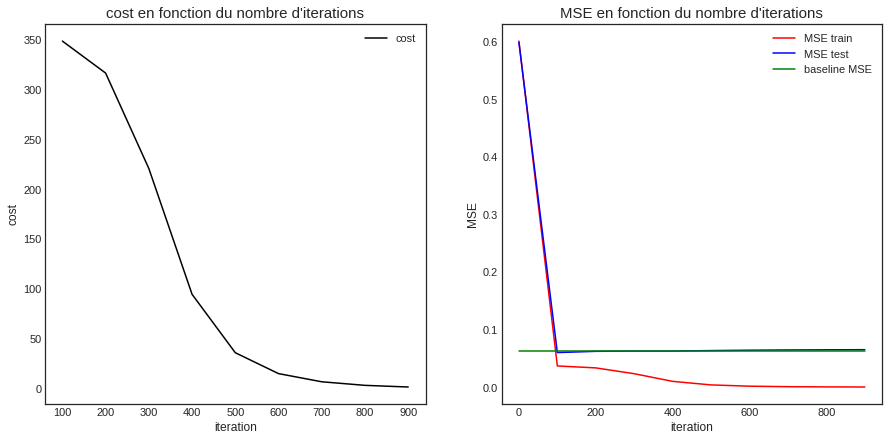

In [11]:
#moyenne item
baseline = tf.constant(np.tile(np.array(df.mean(axis=0)),(1423,1)) / 10.)

#latent factors
k = 100
shape = df.shape

#constante: la matrice R à reconstituer entièrement
R = tf.constant(df.values / 10) #divisée par 10 pour obtenir des notes entre 0 et 1

#variable tensorflow masque
mask_tf_train = tf.Variable(train)
mask_tf_test = tf.Variable(test)

#variables tensorflow
#U et I initialisés selon une loi normale et normalisés en divisant par k
U = tf.Variable(np.abs(np.random.normal(scale=1./k, size=(shape[0], k)).astype(np.float64)), name="U")
I = tf.Variable(np.abs(np.random.normal(scale=1./k, size=(k, shape[1])).astype(np.float64)), name="I")

R_pred = tf.matmul(U, I) #embeddings

#beta: paramètre de regularization
beta = tf.constant(0.0001, dtype=tf.float64, name="beta")
regularizer = beta * (tf.reduce_sum(tf.square(U)) + tf.reduce_sum(tf.square(I)))

#cout de l'algo NMF, norme matricielle de R - R_pred
cost = tf.reduce_sum(tf.square(tf.boolean_mask(R, mask_tf_train) - tf.boolean_mask(R_pred, mask_tf_train)))
cost += regularizer

#contraintes de non-négativité de U et I
clip_U = U.assign(tf.maximum(tf.zeros_like(U), U))
clip_I = I.assign(tf.maximum(tf.zeros_like(I), I))
clip = tf.group(clip_U, clip_I)

#erreur MSE train
mse_train = tf.reduce_mean(tf.square(tf.boolean_mask(R_pred, mask_tf_train) - tf.boolean_mask(R, mask_tf_train)), name="mse_train")
mse_test = tf.reduce_mean(tf.square(tf.boolean_mask(R_pred, mask_tf_test) - tf.boolean_mask(R, mask_tf_test)), name="mse_test")

#baseline MSE test
baselineMSE = tf.reduce_mean(tf.square(tf.boolean_mask(baseline, mask_tf_test) - tf.boolean_mask(R, mask_tf_test)))

alpha = 0.001 #learning rate
global_step = tf.Variable(0, trainable=False)

optimizer = tf.train.AdamOptimizer(alpha).minimize(cost, global_step=global_step)

steps = 1000
costs = []
mses_train = []
mses_test = []

sess = tf.Session()
sess.run(tf.initialize_all_variables())
for i in range(steps):
    sess.run(optimizer)
    sess.run(clip)
    if i%100==0:
        cst = sess.run(cost)
        msetrain = sess.run(mse_train)
        msetest = sess.run(mse_test)
        costs.append((i, cst))
        mses_train.append((i, msetrain))
        mses_test.append((i, msetest))
        
            
learnt_U = sess.run(U)
learnt_I = sess.run(I)
msebaseline = sess.run(baselineMSE)
sess.close()

plt.figure(figsize=(15,7))
plt.subplot(1,2, 1)
plt.title("cost en fonction du nombre d'iterations", fontsize=15)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.plot([a for a,b in costs[1:]], [b for a,b in costs[1:]], color="black", label="cost")
plt.legend()

plt.subplot(1,2, 2)
plt.title("MSE en fonction du nombre d'iterations", fontsize=15)
plt.xlabel("iteration")
plt.ylabel("MSE")
plt.plot([a for a,b in mses_train], [b for a,b in mses_train], color="red", label="MSE train")
plt.plot([a for a,b in mses_test], [b for a,b in mses_test], color="blue", label="MSE test")
plt.plot([a for a,b in mses_test], [msebaseline]*len(mses_train), color="green", label="baseline MSE")
plt.legend()
plt.show()

In [12]:
xptdr = np.clip(np.round(np.dot(learnt_U, learnt_I) * 10), a_min=0, a_max=10)
print("dimensions de la matrice reconstituée: ", xptdr.shape)

dimensions de la matrice reconstituée:  (1423, 726)


In [13]:
xptdr

array([[ 9.,  9.,  9., ...,  7.,  8.,  8.],
       [ 9.,  9.,  8., ...,  7.,  7.,  7.],
       [ 4.,  5.,  5., ...,  4.,  3.,  4.],
       ...,
       [ 8.,  7.,  8., ...,  6.,  6.,  6.],
       [ 7.,  7.,  6., ...,  5.,  6.,  5.],
       [ 9., 10., 10., ...,  8.,  8.,  8.]])

les notes observées ont bien été reconstituées!

## Un peu d'hyperparameters tuning s'impose:

Une étpe cruciale maintenant, chercher les paramètre optimaux correspondants à notre modèle sur notre tâche.

Dans notre cas, les hyper paramètres sont:
- le ***nombre de facteurs (${k}$)***, qui peut favoriser le sur apprentissage,
- le coefficient **${\beta}$** qui est notre ***coefficient de régularization L1***,
- le ***nombre d'itérations***,
- le ***learning rate (taux d'apprentissage)***, qui règle la "vitesse de convergence",
- et...
- l'initialisation et la méthode d'optimisation, qui ne sont pas à proprement parler des hyperparamètres mais sur lesquels nous pouvons nous poser des questions et tester plusieurs variantes.

> Pour se comparer à quoi, par rapport à quoi?

La factorisation de matrices très sparse est un problème difficile très sujet au sur apprentissage. Nous séparons nos données observées (les données connues) en ensemble train/test, par exemple, 20% de données en test et 80% en train. Lors de la phase d'apprentissage, l'algorithme ne verra que les données de test. On comparera alors, par une erreur MSE (mean squarred error) l'erreur faite en prédisant les données de test avec les paramètres ${U}$ et ${I}$ appris par l'algorithme à l'erreur MSE faite par la baseline sur les données de test.

La baseline, ici est simple: pour chaque item, la note qu'un user lui donnera sera la note moyenne de cet item parmi les notes observées. ${\hat{R_{i,j}}^{baseline} = \frac{1}{nbUsers} \sum_{i=1}^{nbUsers} R_{i,j}^O}$ #c'est moche beurk



In [27]:
from recommenders.matrixFactorization import NMF #implémentation sous forme de classe!

### Cherchons un paramètre de régularisation optimal (pour ${k = 100}$)

In [28]:
test_mse = []
for b in [1., 0.1, 0.01, 0.001, 0.0001]:
    nmf = NMF(100)
    learnt_U, learnt_I, results = nmf.run(df, train, test, 10000, b, alpha=0.001, verbose=False)
    test_mse.append(results['mse_test'][-1][1])

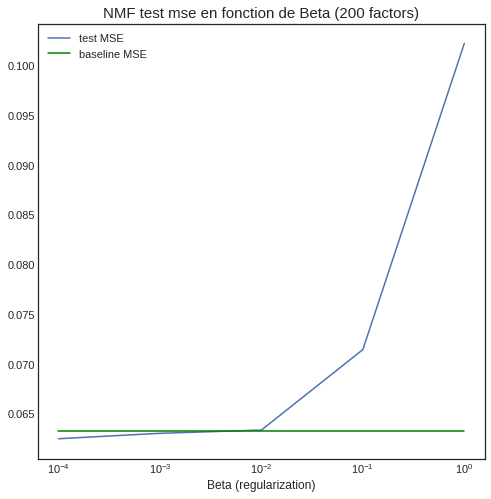

In [30]:
plt.figure(figsize=(8,8))
plt.title("NMF test mse en fonction de Beta (200 factors)", fontsize=15)
plt.xscale('log')
plt.plot([1., 0.1, 0.01, 0.001, 0.0001],test_mse, label="test MSE")
plt.plot([1., 0.1, 0.01, 0.001, 0.0001], [msebaseline]*len(test_mse), color="green", label="baseline MSE")
plt.xlabel("Beta (regularization)")
plt.legend()
plt.show()

In [ ]:
test_mse = []

for k in [5, 10, 50, 100, 200, 300]:
    nmf = NMF(k)
    learnt_U, learnt_I, results = nmf.run(df, train, test, 8000, 0.0001, alpha=0.001, verbose=False)
    test_mse.append(results['mse_test'][-1][1])
    
plt.figure(figsize=(8,8))
plt.title("NMF test mse en fonction de K", fontsize=15)
plt.plot([2, 5, 7, 10, 15, 17, 20, 22, 25, 27, 30, 32, 35, 37, 40, 45, 50],test_mse, label="test MSE")
plt.plot([2, 5, 7, 10, 15, 17, 20, 22, 25, 27, 30, 32, 35, 37, 40, 45, 50], [msebaseline]*len(test_mse), color="red", label="baseline MSE")
plt.xlabel("K (nb latent factors)")
plt.legend()
plt.show()

## Et maintenant, nous pouvons visualiser le résultat:

Les matrices ${U}$ et ${I}$ apprises par NMF nous donnent une information:

Visualisons les embeddings de la matrice ${I}$

In [11]:
#sauvegarde des embeddings appris pour les visualiser dans tensorboard
np.savetxt(f"imdb_vectors.tsv", learnt_I.transpose(), delimiter="\t")
with open(f"imdb_metadata.tsv","w") as metadata_file:
    for x in serie_dict: #hack for space
        x = " ".join(x.split("_")[1:])
        if len(x.strip()) == 0:
            x = f"space-{len(x)}"
        metadata_file.write(f"{x}\n")

In [55]:
user = 5

lol = [(i,a) for i, a in enumerate(df.iloc[user].values) if not np.isnan(a)]
lol.sort(key=lambda x: x[1])
print("notes observées: \n")
for i, rating in lol[::-1]:
    print(rating,"\t"," ".join(serie_dict[i].split("_")[1:]))
    
hhhh = [a for a,b in lol]
mdr = [a for a in np.argsort(xptdr[user])[::-1] if a not in hhhh]
print("\nséries recommandées: \n")
for i in mdr[:5]:
    print(xptdr[user][i],"\t", " ".join(serie_dict[i].split("_")[1:]))

notes observées: 

10.0 	 Breaking Bad
8.0 	 New Tricks
8.0 	 Agatha Christie Poirot
7.0 	 Southland
7.0 	 Rules of Engagement
7.0 	 Scrubs
5.0 	 Rejseholdet (Unit One)

séries recommandées: 

9.0 	 Narcos
9.0 	 The World at War
9.0 	 The Venture Bros.
9.0 	 Father Ted
9.0 	 Oz


### SVD++ (Singular Value Decomposition ++):

**SVD++** est un autre algorithme connu de factorisation de matrice. Il lève la contrainte de non-négativité sur ${U}$ et ${I}$ et rajoute 3 autres valeurs, ${b}$, ${bU_{i}}$, et ${bI_{j}}$. Comme son nom l'indique, il s'agit d'une version modifiée de l'algorithme SVD.

on calcule en fait ${\hat{R_{i,j}}= \mu + \mu U_{i} + \mu I_{j} + U_{i}\cdot I_{j}}$. Voici pourquoi:

>Supposons que vous voulez une estimation de la note de Jean-Rachid sur le film Taxi 3. Supposons que la moyenne des notes sur tous les films, µ, est 6.7 étoiles. De plus, Taxi 3 a une meilleure moyenne que la moyenne des films, et il a tendance à être noté 0.5 étoiles au-dessus de la moyenne, grace au jeu d'acteur incroyable de Fred Diefenthal. De plus, Jean-Rachid est un cinéphile critique, qui a tendance à noter 0.3 étoiles en-dessous de la moyenne. Donc, une estimation de la note de Jean-Rachid sur Taxi 3 serait 6.9 étoiles (6.7 + 0.5 - 0.3).

On introduit donc une baseline, matérialisée par 3 variables, qui ne sont pas apprises par l'algorithme (donc pas modifiées).

${\mu}$ représente la moyenne globale: c'est la moyenne de **toutes** les notes, pour tous les films. ${\mu U}$ est un vecteur de taille ${m}$ qui contient pour chaque utilisateur sa déviation par rapport à la moyenne ${\mu}$ (comme dans l'exemple ci-dessus avec Jean-Rachid). ${\mu I}$ est un vecteur de taille ${n}$ qui contient pour chaque item (série, ici) sa déviation par rapport à la note moyenne. On ne reconstitue alors que la déviation par rapport à ces 3 paramètres.


Le code sous forme de classe se trouve dans <a href="https://github.com/ismaelbonneau/movie_recommender/tree/master/recommenders">le package recommenders</a>

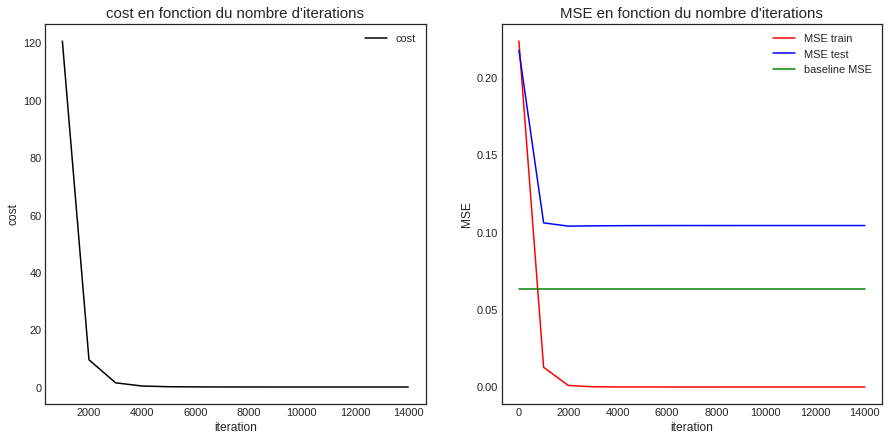

In [34]:
from recommenders.matrixFactorization import SVDpp

train = df.notnull().values
test_size = 0.2
test = train.copy()

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if train[i,j]:
            if random.random() < test_size:
                #ajouter dans test et enlever de train
                train[i,j] = False
            else:
                test[i,j] = False       

svdpp = SVDpp(200)
U, I, b_U, b_I, b, params = svdpp.run(df, train, test, 15000, 0.0001, alpha=0.001, verbose=False)

costs = params["cost"]
mses_train = params["mse_train"]
mses_test = params["mse_test"]

plt.figure(figsize=(15,7))
plt.subplot(1,2, 1)
plt.title("cost en fonction du nombre d'iterations", fontsize=15)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.plot([a for a,b in costs[1:]], [b for a,b in costs[1:]], color="black", label="cost")
plt.legend()

plt.subplot(1,2, 2)
plt.title("MSE en fonction du nombre d'iterations", fontsize=15)
plt.xlabel("iteration")
plt.ylabel("MSE")
plt.plot([a for a,b in mses_train], [b for a,b in mses_train], color="red", label="MSE train")
plt.plot([a for a,b in mses_test], [b for a,b in mses_test], color="blue", label="MSE test")
plt.plot([a for a,b in mses_test], [0.06369]*len(mses_train), color="green", label="baseline MSE")
plt.legend()
plt.show()

### Cherchons un paramètre de régularisation optimal (pour ${k = 200}$)

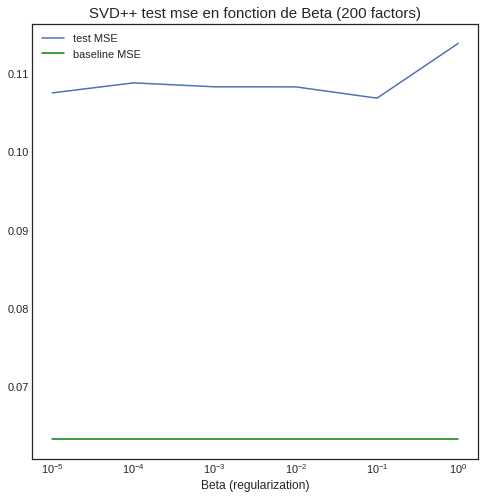

In [36]:
test_mse = []
for beta in [1., 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    svdpp = SVDpp(200)
    U, I, b_U, b_I, b, params = svdpp.run(df, train, test, 12000, beta, alpha=0.001, verbose=False)
    test_mse.append(params['mse_test'][-1][1])
    
plt.figure(figsize=(8,8))
plt.title("SVD++ test mse en fonction de Beta (200 factors)", fontsize=15)
plt.xscale('log')
plt.plot([1., 0.1, 0.01, 0.001, 0.0001, 0.00001],test_mse, label="test MSE")
plt.plot([1., 0.1, 0.01, 0.001, 0.0001, 0.00001], [msebaseline]*len(test_mse), color="green", label="baseline MSE")
plt.xlabel("Beta (regularization)")
plt.legend()
plt.show()

#### Performances de nos algorithmes en test:

| **modèle**      |     5 factors   |   10 factors |   50 factors  |   100 factors   |   200 factors  |
| ------------- |: -------------: | ---------: | ---------: | ---------: | ---------: |
| **baseline**      |        0.06369        |      0.06369 |      0.06369 |      0.06369 |      0.06369 |
| **NMF**     |        0.0932        |     0.0871  |       0.08216229 |       0.0885220 |       **0.062480799** |
| **SVD++**     |        0.170291        |      0.145761 |      0.11668 |       0.1120696 |       0.104418166 |


### Revenons sur l'algorithme NMF:

Bien, nous avons vu qu'avec un paramètre ${\beta}$ de régularization et un nombre de facteurs ${k}$ bien choisis, le modèle NMF était le meilleur et arrivait même à dépasser la base line, plutôt solide.

Une étape est fondamentale dans le déroulement de l'algorithme, c'est l'étape de l'initialisation. En effet, dans le cadre de la NMF sur des matrices comportant des valeurs manquantes, la fonction à minimiser est non convexe.

<img src="images/convex_vs_nonconvex.png" width="800" >

Une fonction non convexe peut comporter plusieurs minimums locaux. Dans ce cas là, le risque pour l'algorithme est de rester coincé dans un optimum local. Il est alors important de choisir l'étape d'initialisation de l'algorithme afin de ne pas tomber dans cet optimum local. Jusqu'à présent, nous choisissions d'initialiser les matrices ${U}$ et ${I}$ avec des valeurs aléatoires tirées selon une loi normale.



### Vers une méthode d'initialisation plus performante:

parler de ICA, PCA pour initialisation. Parler de Adam vs. gradient descent.